In [135]:
%pylab inline

#### Load constants ####
import scipy.constants as sc

import matplotlib as mpl
import glob
import os

import sys

import adios2

from scipy.optimize import curve_fit
import numpy as np

# OVERWRITE DEFAULT PLOTTING PARAMETERS
params = {
    'font.family' : 'sans-serif',
    'font.sans-serif' : ['DejaVu Sans', 'Arial', 'Verdana', 'Liberation Sans'],
    'mathtext.default' : 'regular',
    'mathtext.rm' : 'sans',
    'font.size' : 18,
    'legend.fontsize' : 14,
    'axes.labelsize' : 18,
    'axes.titlesize' : 16,
    'lines.linewidth' : 3.0,
    'legend.frameon' : False,
    'legend.numpoints': 1,
}

matplotlib.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


/home/mricht11/sw/miniconda3/envs/picongpu-analysis/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
λ_0 = 0.8e-6
τ= 30.e-15
w_0 = 4.0e-6 / 1.17741

λ_r = 1 * sc.pi * w_0 / λ_0

σ_Ω = np.sqrt(2) / τ
Ω_0 = 2 * np.pi * sc.c / λ_0

In [3]:
def w(y):
    return np.sqrt(w_0**2 * (1 + (λ/z_r)**2))

In [35]:
# Set path and check simulation output files
path = ("/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput/")

files = glob.glob(path + "/openPMD/" + "*.bp")
files.sort(key=os.path.getmtime)

print("Number of files = %i"%(len(files)))

print(files)

Number of files = 16
['/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_000000.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_000200.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_000400.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_000600.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_000800.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_001000.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_001200.bp', '/bigdata/hplsim/scratch/mricht11/incident_Gauss/Gausspuls_low_res_initback_002/simOutput//openPMD/simData_001400.bp', '/bigdata/hplsim/scratch/m

In [36]:
f = adios2.open(files[0], "r")

print("index order:", f.read_attribute_string("/data/0/fields/B/axisLabels"))

Nz, Ny, Nx = array(f.available_variables().get("/data/0/fields/B/x")['Shape'].split(', '), dtype=int)
print("Nz = %i, Ny = %i, Nx = %i"%(Nz,Ny,Nx))

unit_length_SI = f.read_attribute("/data/0/unit_length")
Dy_SI = f.read_attribute("/data/0/cell_height") * unit_length_SI
Dx_SI = f.read_attribute("/data/0/cell_width") * unit_length_SI
Dz_SI = Dx_SI

unit_time_SI = f.read_attribute("/data/0/unit_time")
Dt_SI = f.read_attribute("/data/0/dt") * unit_time_SI
print("Δt = %es"%(Dt_SI))

f.close()

print("Simulation Box lengths:")
print("x = "+ str(Dx_SI* Nx))
print("y = "+ str(Dy_SI* Ny))
print("z = "+ str(Dz_SI* Nz))

index order: ['z', 'y', 'x']
Nz = 176, Ny = 960, Nx = 176
Δt = 1.489691e-16s
Simulation Box lengths:
x = [1.76000002e-05]
y = [9.6000001e-05]
z = [1.76000002e-05]


In [37]:
for i in array([8]): #arange(len(files)): # Set timesteps to analyze
    
    #Load data
    f = adios2.open(files[i], "r")
    
    #extract time step
    t_i = int((files[i].rpartition('_')[2]).rpartition('.')[0])
    #print(t_i)
    
    unit_efield = f.read_attribute("/data/%i/fields/E/x/unitSI"%(t_i))[0]
    Ex = np.array(f.read("/data/%i/fields/E/x"%(t_i))*unit_efield)
    Ez = np.array(f.read("/data/%i/fields/E/z"%(t_i)) * unit_efield)
    Ey = np.array(f.read("/data/%i/fields/E/y"%(t_i))*unit_efield)
    
    
    unit_bfield = f.read_attribute("/data/%i/fields/B/x/unitSI"%(t_i))[0]
    Bz = np.array(f.read("/data/%i/fields/B/z"%(t_i))*unit_bfield)
    Bx = np.array(f.read("/data/%i/fields/B/x"%(t_i))*unit_bfield)
    By = np.array(f.read("/data/%i/fields/B/y"%(t_i))*unit_bfield)
    
    f.close()

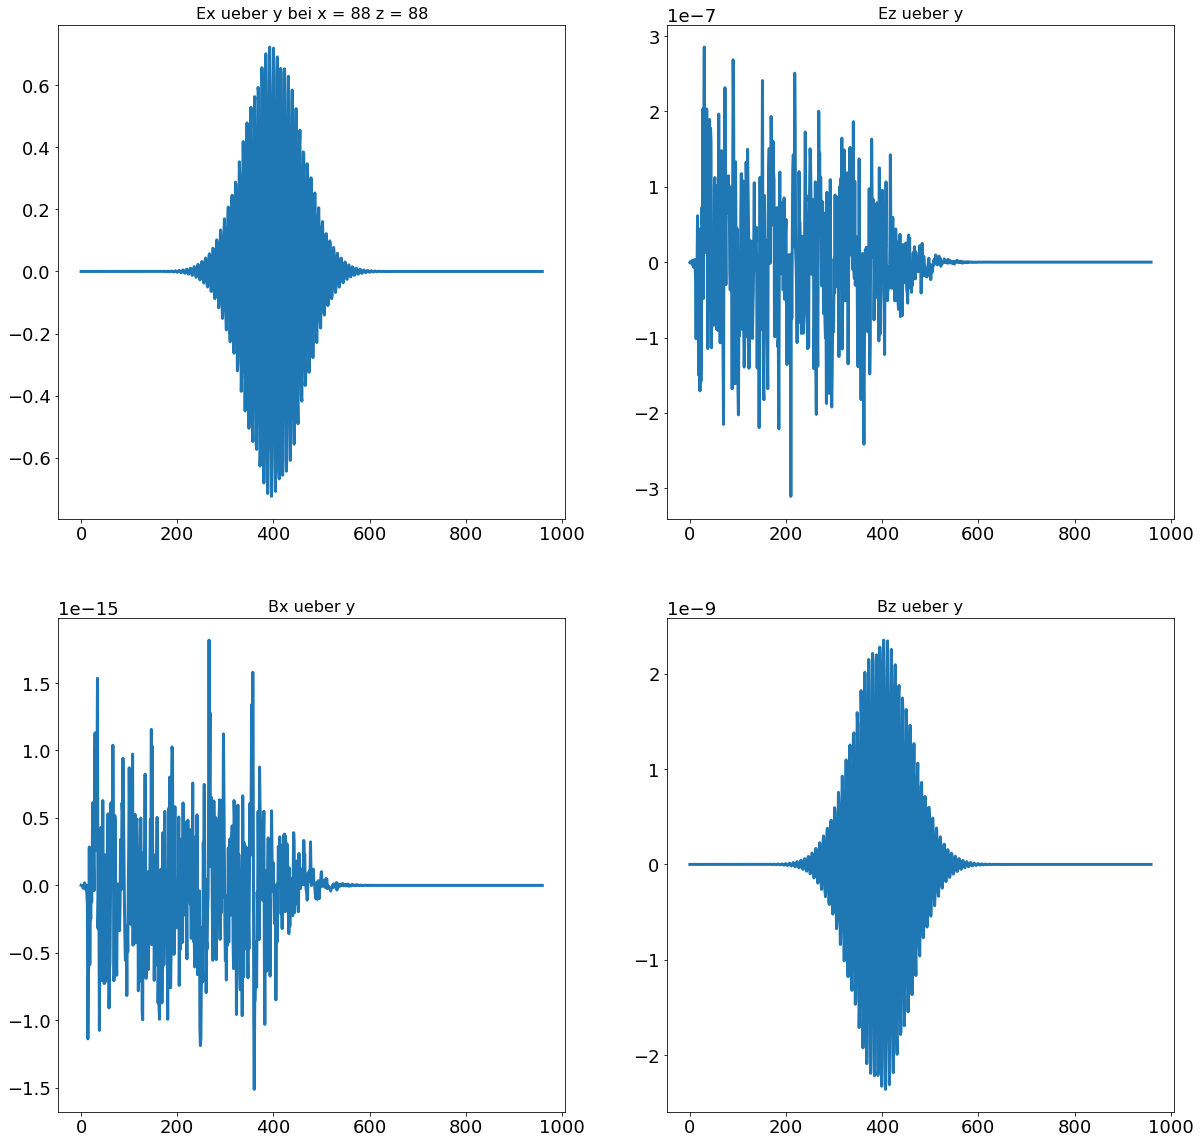

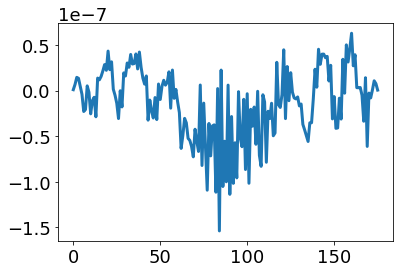

In [39]:
y_axis = np.arange(Ny)
x_axis = np.arange(Nz)
z_axis = np.arange(Nx)

#intersections
n_x = 88
n_y = 100
n_z = 88


fig = figure(figsize = (20,20))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(y_axis, Ex[n_x,:,n_z])
ax1.set_title("Ex ueber y bei x = "+ str(n_x)+" z = "+ str(n_z))

ax2 = fig.add_subplot(2,2,2)
ax2.plot(y_axis, Ez[n_x,:,n_z])
ax2.set_title("Ez ueber y")

ax3 = fig.add_subplot(2,2,3)
ax3.plot(y_axis, Bx[n_x,:,n_z])
ax3.set_title("Bx ueber y")

ax4 = fig.add_subplot(2,2,4)
ax4.plot(y_axis, Bz[n_x,:,n_z])
ax4.set_title("Bz ueber y")

plt.figure() 
plot(x_axis, Ex[128,16,:])


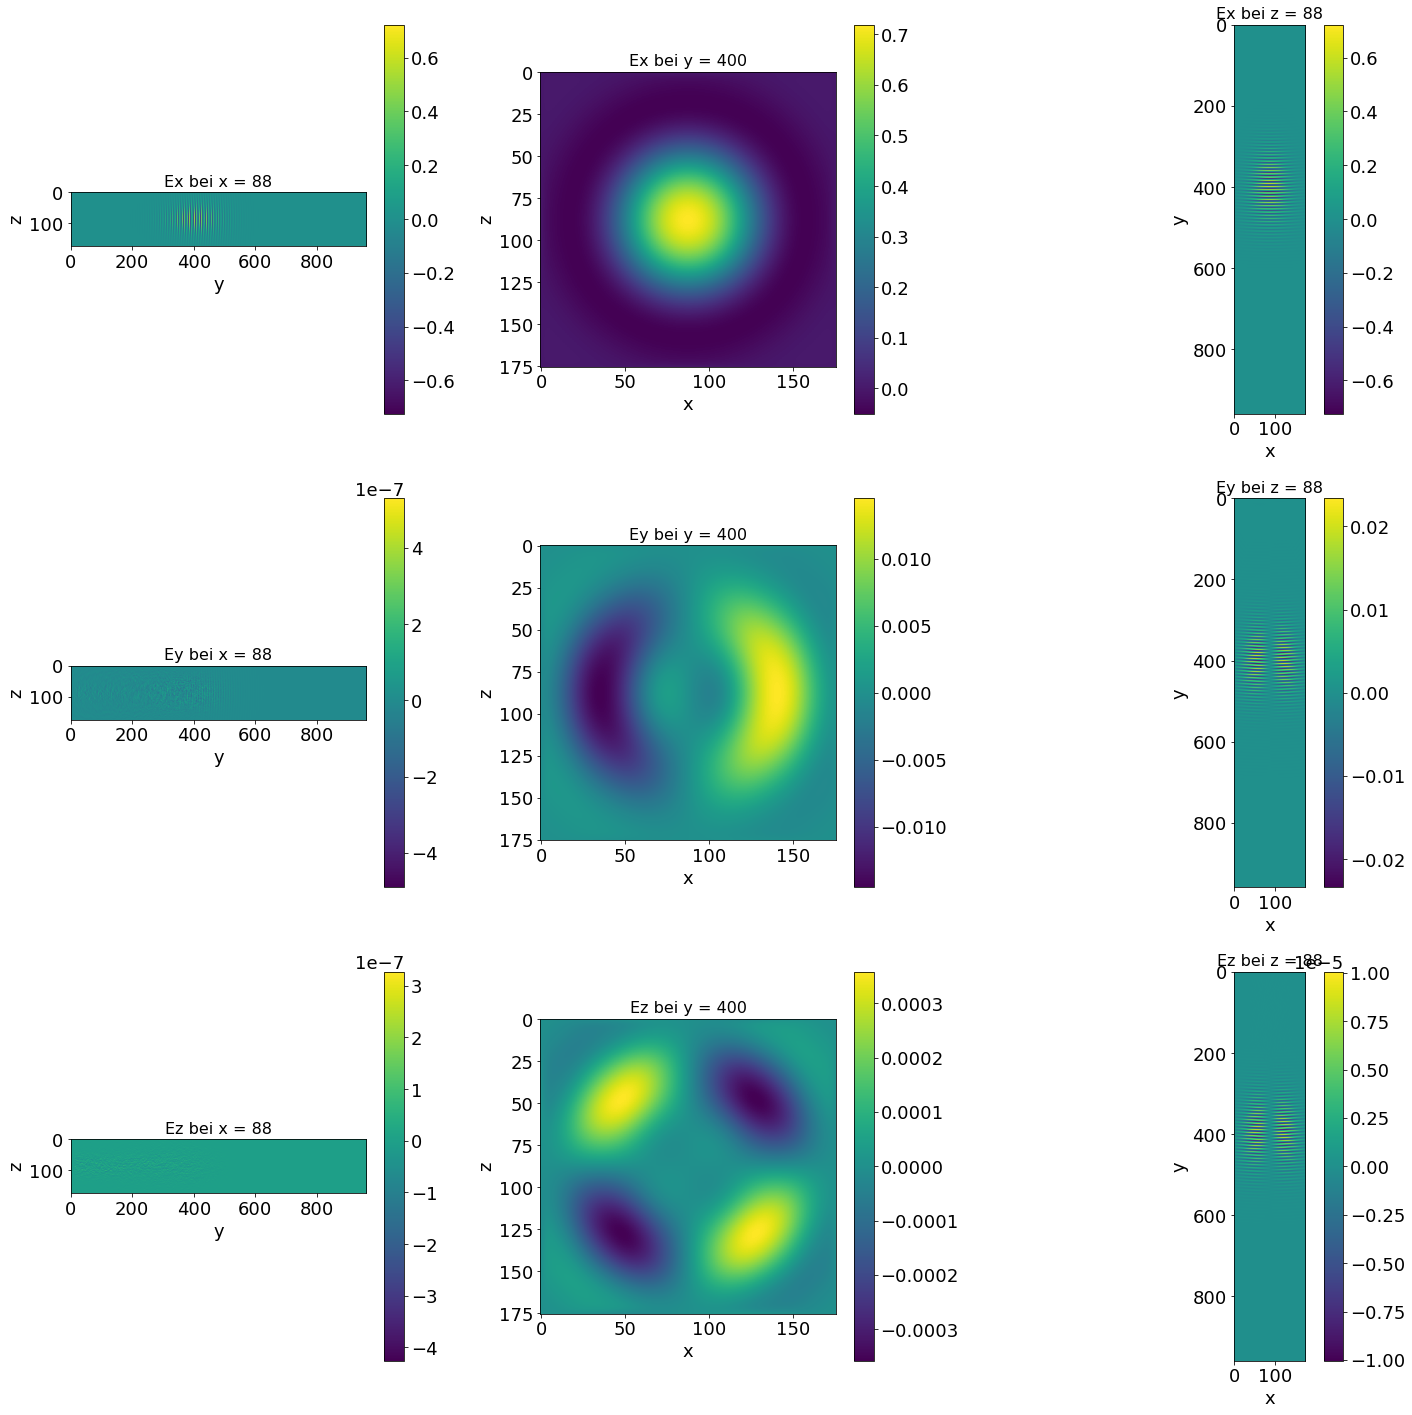

In [40]:
n_x = 88
n_y = 400
n_z = 88
fig2 = figure(figsize = (20,20))
ax21 = fig2.add_subplot(3,3,1)
pos1 = ax21.imshow(Ex[:,:,n_x])
ax21.set_title("Ex bei x = "+str(n_x))
ax21.set_xlabel("y")
ax21.set_ylabel("z")
fig2.colorbar(pos1)

ax22 = fig2.add_subplot(3,3,2)
pos2 = ax22.imshow(Ex[:,n_y,:])
ax22.set_title("Ex bei y = "+str(n_y))
ax22.set_xlabel("x")
ax22.set_ylabel("z")
fig2.colorbar(pos2)

ax23 = fig2.add_subplot(3,3,3)
pos3 = ax23.imshow(Ex[n_z,:,:])
ax23.set_title("Ex bei z = "+str(n_z))
ax23.set_xlabel("x")
ax23.set_ylabel("y")
fig2.colorbar(pos3)

ax24 = fig2.add_subplot(3,3,4)
pos4 = ax24.imshow(Ey[:,:,n_x])
ax24.set_title("Ey bei x = "+str(n_x))
ax24.set_xlabel("y")
ax24.set_ylabel("z")
fig2.colorbar(pos4)

ax25 = fig2.add_subplot(3,3,5)
pos5 = ax25.imshow(Ey[:,n_y,:])
ax25.set_title("Ey bei y = "+str(n_y))
ax25.set_xlabel("x")
ax25.set_ylabel("z")
fig2.colorbar(pos5)

ax26 = fig2.add_subplot(3,3,6)
pos6 = ax26.imshow(Ey[n_z,:,:])
ax26.set_title("Ey bei z = "+str(n_z))
ax26.set_xlabel("x")
ax26.set_ylabel("y")
fig2.colorbar(pos6)

ax27 = fig2.add_subplot(3,3,7)
pos7 = ax27.imshow(Ez[:,:,n_x])
ax27.set_title("Ez bei x = "+str(n_x))
ax27.set_xlabel("y")
ax27.set_ylabel("z")
fig2.colorbar(pos7)

ax28 = fig2.add_subplot(3,3,8)
pos8 = ax28.imshow(Ez[:,n_y,:])
ax28.set_title("Ez bei y = "+str(n_y))
ax28.set_xlabel("x")
ax28.set_ylabel("z")
fig2.colorbar(pos8)

ax29 = fig2.add_subplot(3,3,9)
pos9 = ax29.imshow(Ez[n_z,:,:])
ax29.set_title("Ez bei z = "+str(n_z))
ax29.set_xlabel("x")
ax29.set_ylabel("y")
fig2.colorbar(pos9)

fig2.tight_layout()

fig2.savefig('Incident Field E Gauss Y_min.png')



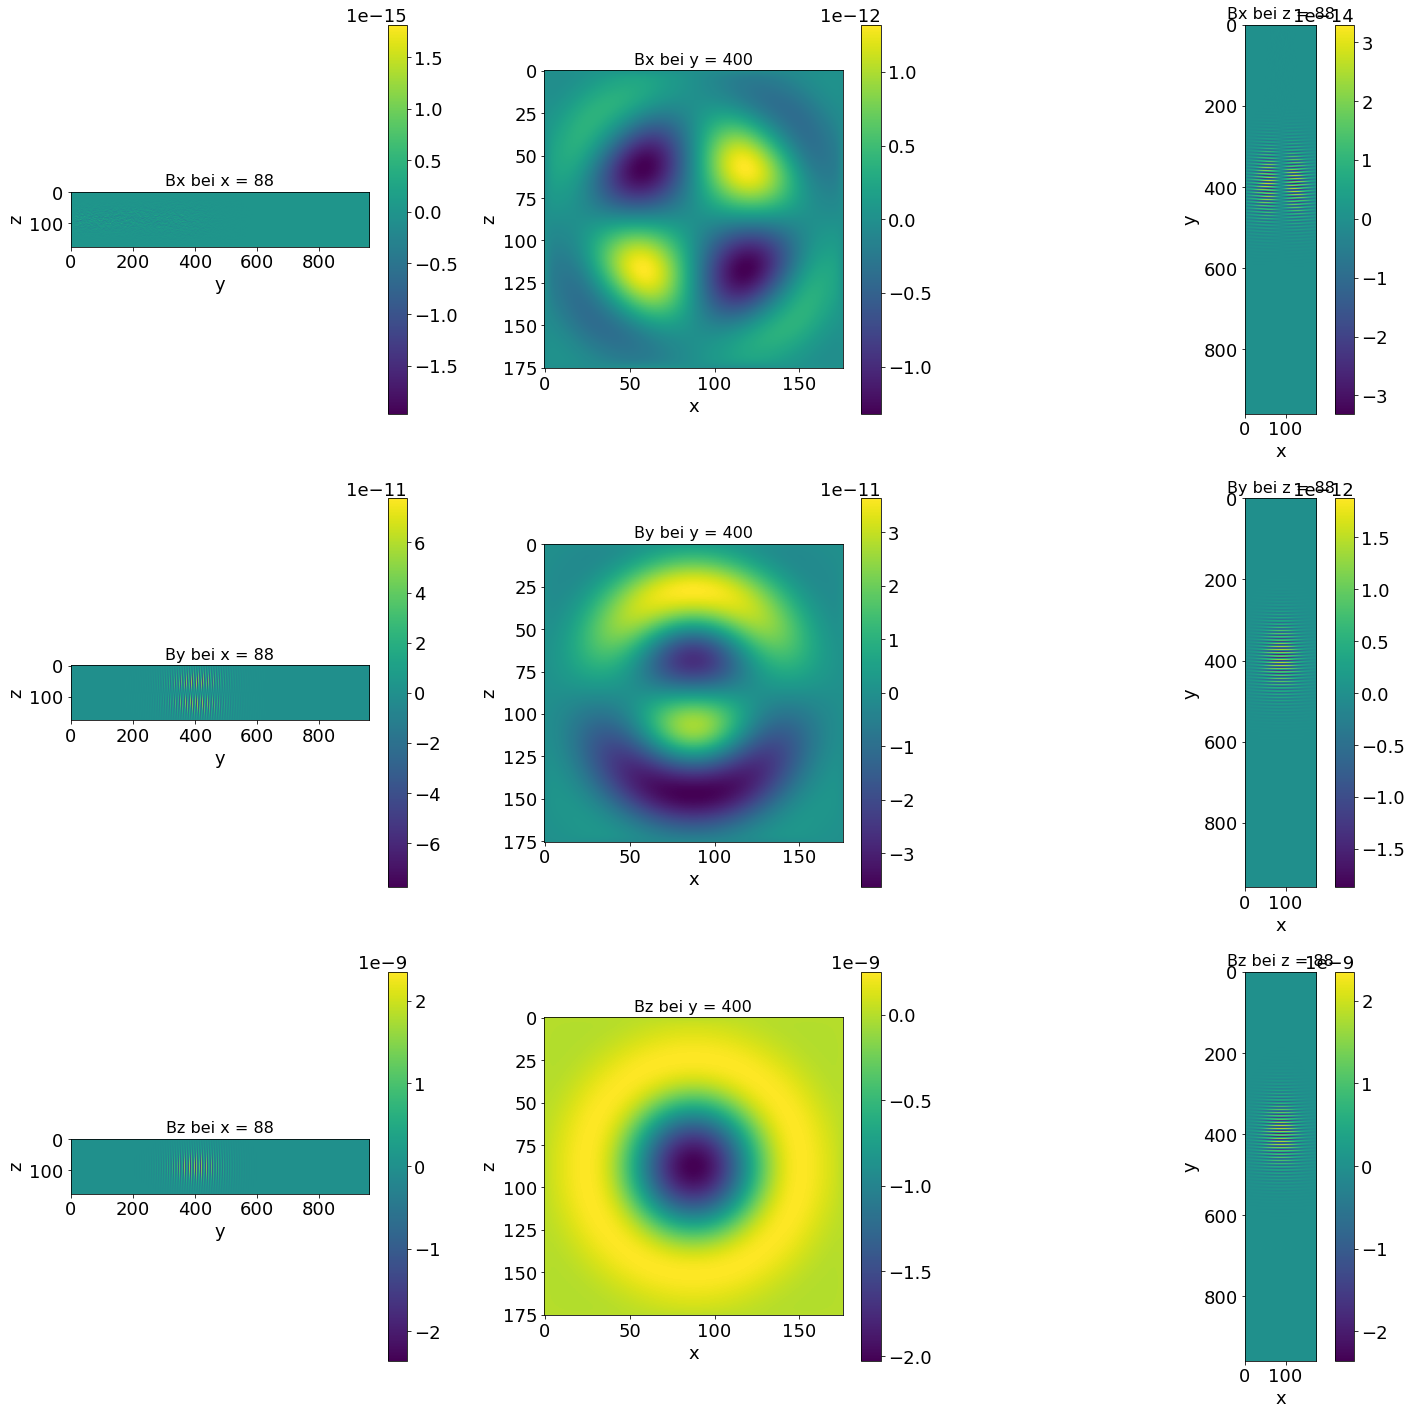

In [134]:
n_x = 88
n_y = 400
n_z = 88
fig3 = figure(figsize = (20,20))
ax31 = fig3.add_subplot(3,3,1)
pos10 = ax31.imshow(Bx[:,:,n_x])
ax31.set_title("Bx bei x = "+str(n_x))
ax31.set_xlabel("y")
ax31.set_ylabel("z")
fig3.colorbar(pos10)

ax32 = fig3.add_subplot(3,3,2)
pos11 = ax32.imshow(Bx[:,n_y,:])
ax32.set_title("Bx bei y = "+str(n_y))
ax32.set_xlabel("x")
ax32.set_ylabel("z")
fig3.colorbar(pos11)

ax33 = fig3.add_subplot(3,3,3)
pos12 = ax33.imshow(Bx[n_z,:,:])
ax33.set_title("Bx bei z = "+str(n_z))
ax33.set_xlabel("x")
ax33.set_ylabel("y")
fig3.colorbar(pos12)

ax34 = fig3.add_subplot(3,3,4)
pos13 = ax34.imshow(By[:,:,n_x])
ax34.set_title("By bei x = "+str(n_x))
ax34.set_xlabel("y")
ax34.set_ylabel("z")
fig3.colorbar(pos13)

ax35 = fig3.add_subplot(3,3,5)
pos14 = ax35.imshow(By[:,n_y,:])
ax35.set_title("By bei y = "+str(n_y))
ax35.set_xlabel("x")
ax35.set_ylabel("z")
fig3.colorbar(pos14)

ax36 = fig3.add_subplot(3,3,6)
pos15 = ax36.imshow(By[n_z,:,:])
ax36.set_title("By bei z = "+str(n_z))
ax36.set_xlabel("x")
ax36.set_ylabel("y")
fig3.colorbar(pos15)

ax37 = fig3.add_subplot(3,3,7)
pos16 = ax37.imshow(Bz[:,:,n_x])
ax37.set_title("Bz bei x = "+str(n_x))
ax37.set_xlabel("y")
ax37.set_ylabel("z")
fig3.colorbar(pos16)

ax38 = fig3.add_subplot(3,3,8)
pos17 = ax38.imshow(Bz[:,n_y,:])
ax38.set_title("Bz bei y = "+str(n_y))
ax38.set_xlabel("x")
ax38.set_ylabel("z")
fig3.colorbar(pos17)

ax39 = fig3.add_subplot(3,3,9)
pos18 = ax39.imshow(Bz[n_z,:,:])
ax39.set_title("Bz bei z = "+str(n_z))
ax39.set_xlabel("x")
ax39.set_ylabel("y")
fig3.colorbar(pos18)
fig3.tight_layout()
fig3.savefig('Incident Field B Gauss Y_min.png')

#fig.colorbar(ax = ax31)


In [42]:
# calculation of Energy density

energy_density = sc.epsilon_0 / 2 * (Ex**2 + Ey**2 + Ez**2) + 2/sc.mu_0 * (Bx**2 + By**2 + Bz**2)


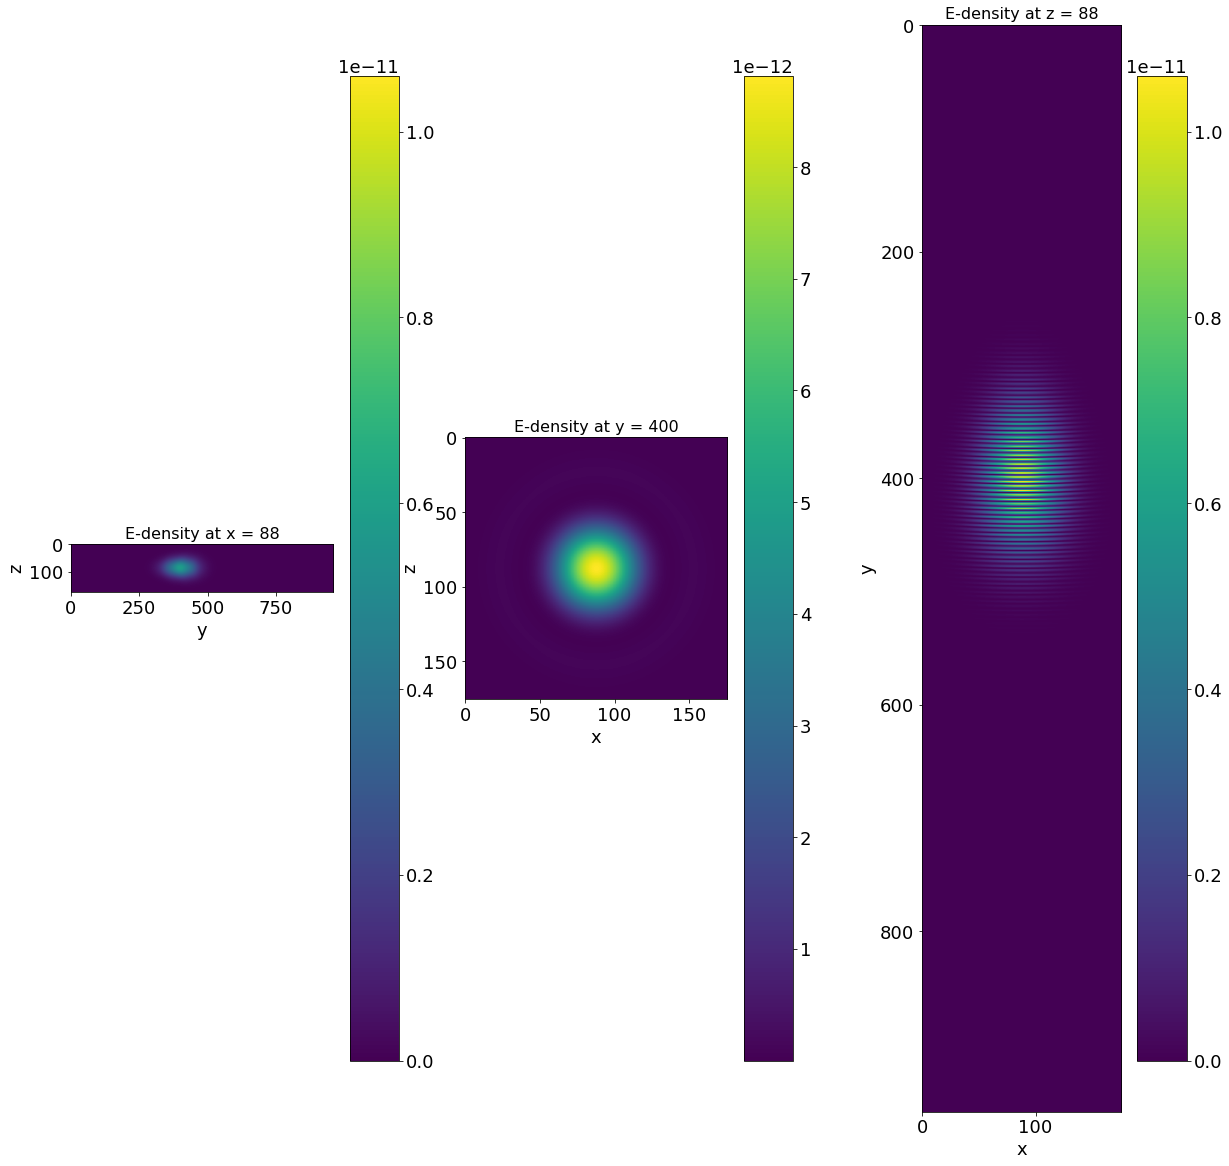

In [43]:
n_x = 88
n_y = 400
n_z = 88
fig4 = figure(figsize = (20,20))
ax41 = fig4.add_subplot(1,3,1)
pos41 = ax41.imshow(energy_density[:,:,n_x])
ax41.set_title("E-density at x = "+str(n_x))
ax41.set_xlabel("y")
ax41.set_ylabel("z")
fig4.colorbar(pos41)

ax42 = fig4.add_subplot(1,3,2)
pos42 = ax42.imshow(energy_density[:,n_y,:])
ax42.set_title("E-density at y = "+str(n_y))
ax42.set_xlabel("x")
ax42.set_ylabel("z")
fig4.colorbar(pos42)

ax43 = fig4.add_subplot(1,3,3)
pos43 = ax43.imshow(energy_density[n_z,:,:])
ax43.set_title("E-density at z = "+str(n_z))
ax43.set_xlabel("x")
ax43.set_ylabel("y")
fig4.colorbar(pos43)


